<a href="https://colab.research.google.com/github/Finkovski/Project2-G2/blob/main/Project2_G2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

# One-hot encode labels
y_train_cat = tf.keras.utils.to_categorical(y_train, 10)
y_test_cat = tf.keras.utils.to_categorical(y_test, 10)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
IMG_SIZE = 160
BATCH_SIZE = 32

def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# Build datasets
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train_cat))
train_ds = train_ds.map(preprocess).shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test_cat))
val_ds = val_ds.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

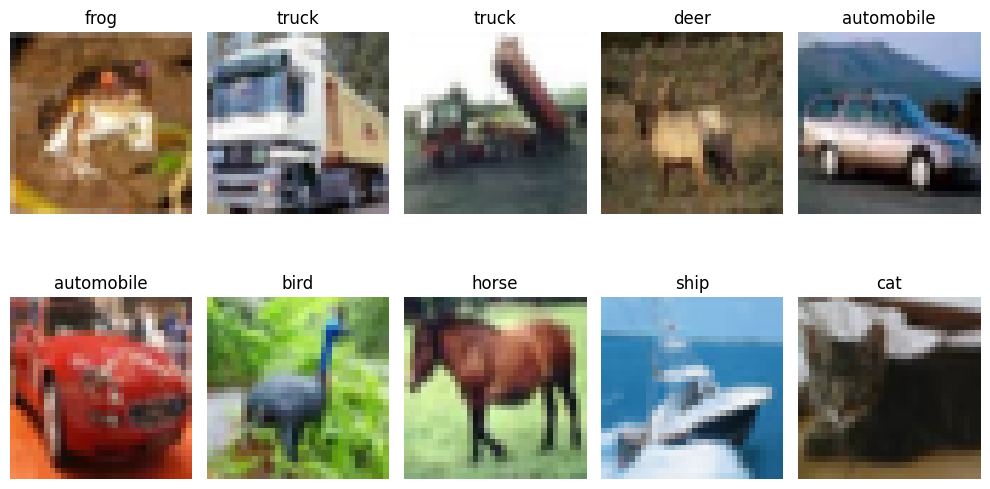

In [ ]:
plt.figure(figsize=(10, 6))
for i in range(10):
    img = x_train[i]
    label = class_names[y_train[i][0]]
    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.title(label)
    plt.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
# Custom CNN Architecture

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def build_custom_cnn(input_shape=(32, 32, 3), num_classes=10):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(2, 2),

        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Compile and train the custom CNN
custom_cnn = build_custom_cnn()
custom_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

from tensorflow.keras.callbacks import EarlyStopping

early_stop_cnn = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_custom_cnn = custom_cnn.fit(
    x_train, y_train_cat,
    validation_data=(x_test, y_test_cat),
    epochs=20,
    batch_size=64,
    callbacks=[early_stop_cnn]
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.2244 - loss: 4.0898 - val_accuracy: 0.4388 - val_loss: 1.5349
Epoch 2/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4271 - loss: 1.5853 - val_accuracy: 0.5259 - val_loss: 1.3303
Epoch 3/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5002 - loss: 1.3948 - val_accuracy: 0.5830 - val_loss: 1.1983
Epoch 4/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5537 - loss: 1.2639 - val_accuracy: 0.6059 - val_loss: 1.1380
Epoch 5/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5804 - loss: 1.1892 - val_accuracy: 0.6127 - val_loss: 1.1485
Epoch 6/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6045 - loss: 1.1207 - val_accuracy: 0.6204 - val_loss: 1.1145
Epoch 7/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6287 - loss: 1.0489 - val_accuracy: 0.6348 - val_loss: 1.0603
Epoch 8/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6469 - loss: 1.0040 - val_accuracy: 0

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Predict on test data
y_pred_cnn = custom_cnn.predict(x_test)
y_pred_classes_cnn = np.argmax(y_pred_cnn, axis=1)
y_true = y_test.flatten()

# Classification report
print("\nClassification Report for Custom CNN:")
print(classification_report(y_true, y_pred_classes_cnn, target_names=class_names))

In [ ]:
# Confusion matrix
cm_cnn = confusion_matrix(y_true, y_pred_classes_cnn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_cnn, display_labels=class_names)

fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(ax=ax, cmap='Blues')
plt.title("Confusion Matrix - Custom CNN")
plt.show()

<ipython-input-6-fd37eeaac66b>:19: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-6-fd37eeaac66b>:19: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


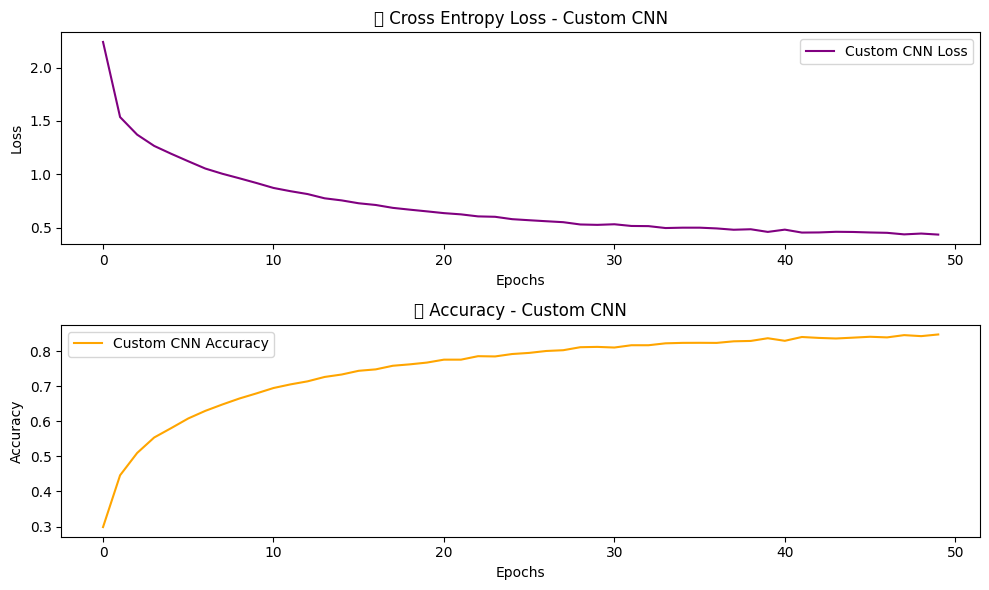

In [ ]:
# Visualization for Custom CNN

plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.plot(history_custom_cnn.history['loss'], label='Custom CNN Loss', color='purple')
plt.title("📉 Cross Entropy Loss - Custom CNN")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(history_custom_cnn.history['accuracy'], label='Custom CNN Accuracy', color='orange')
plt.title("📈 Accuracy - Custom CNN")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False  # freeze base layers

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(10, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)]
)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 40, 40,    │      2,304 │ block_1_depthwis

 Total params: 2,423,242 (9.24 MB)

 Trainable params: 165,258 (645.54 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 54s 28ms/step - accuracy: 0.6964 - loss: 0.8991 - val_accuracy: 0.8121 - val_loss: 0.5465
Epoch 2/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 34s 22ms/step - accuracy: 0.7956 - loss: 0.5956 - val_accuracy: 0.8161 - val_loss: 0.5281
Epoch 3/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 34s 22ms/step - accuracy: 0.8121 - loss: 0.5467 - val_accuracy: 0.8222 - val_loss: 0.5171
Epoch 4/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 34s 21ms/step - accuracy: 0.8219 - loss: 0.5135 - val_accuracy: 0.8293 - val_loss: 0.5097
Epoch 5/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 34s 22ms/step - accuracy: 0.8311 - loss: 0.4813 - val_accuracy: 0.8268 - val_loss: 0.4980
Epoch 6/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 34s 22ms/step - accuracy: 0.8390 - loss: 0.4616 - val_accuracy: 0.8309 - val_loss: 0.5023
Epoch 7/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 34s 22ms/step - accuracy: 0.8443 - loss: 0.4484 - val_accuracy: 0.8283 - val_loss: 0.5240
Epoch 8/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 41s 22ms/step - accuracy: 0.8472 -

In [ ]:
loss, acc = model.evaluate(val_ds)
print(f"Test Accuracy: {acc:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.8270 - loss: 0.5048
Test Accuracy: 0.8268


313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step
              precision    recall  f1-score   support

    airplane       0.85      0.83      0.84      1000
  automobile       0.88      0.93      0.90      1000
        bird       0.77      0.81      0.79      1000
         cat       0.76      0.60      0.67      1000
        deer       0.76      0.80      0.78      1000
         dog       0.77      0.78      0.78      1000
        frog       0.84      0.89      0.86      1000
       horse       0.84      0.87      0.85      1000
        ship       0.89      0.88      0.89      1000
       truck       0.91      0.88      0.90      1000

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000



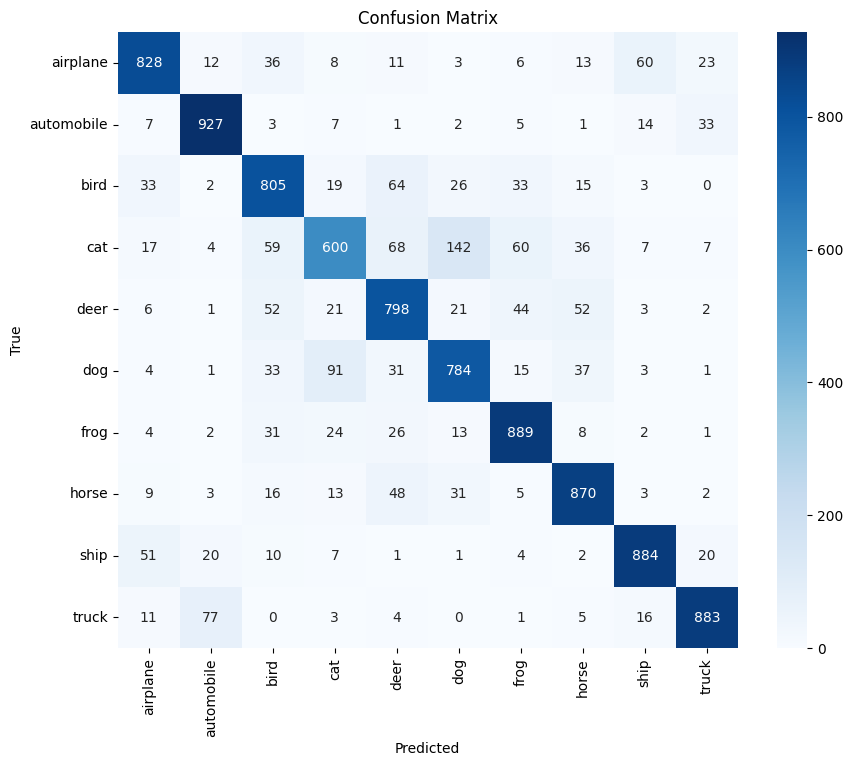

In [ ]:
# Predict
y_pred_probs = model.predict(val_ds)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# Report
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


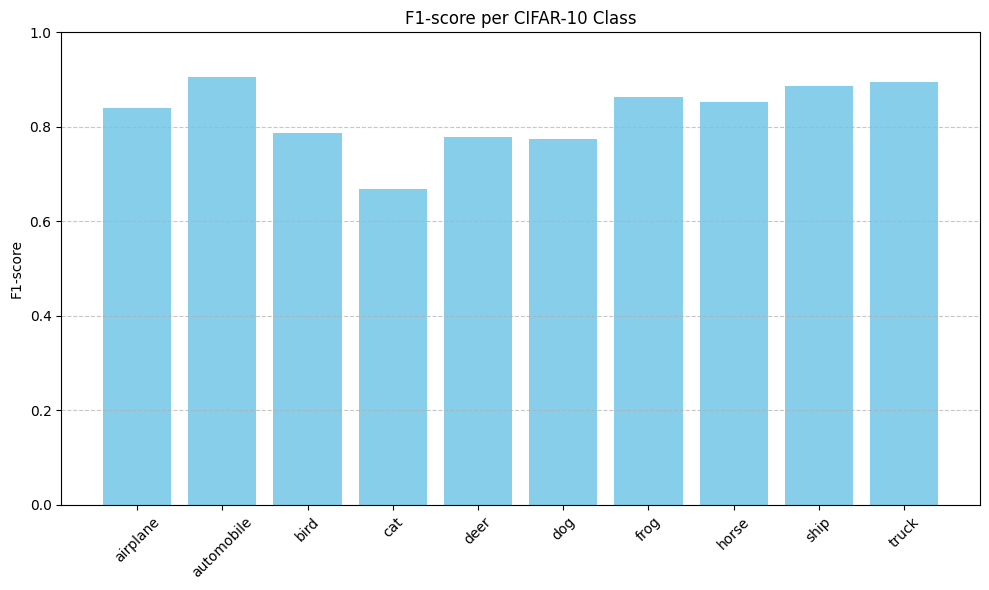

In [ ]:
# Parse classification report into dict
report = classification_report(y_true, y_pred, target_names=[
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'], output_dict=True)

# Extract F1-scores
classes = list(report.keys())[:10]
f1_scores = [report[label]['f1-score'] for label in classes]

# Plot bar chart
plt.figure(figsize=(10, 6))
plt.bar(classes, f1_scores, color='skyblue')
plt.ylabel("F1-score")
plt.title("F1-score per CIFAR-10 Class")
plt.ylim(0, 1.0)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
model.save('cifar10_transfer_model.keras')

In [ ]:
# Unfreeze from layer 100 onwards (out of ~154)
UNFREEZE_FROM = 100

# Unfreeze the base model
base_model.trainable = True

# Freeze all layers before `UNFREEZE_FROM`
for i, layer in enumerate(base_model.layers):
    layer.trainable = i >= UNFREEZE_FROM


In [ ]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history_finetune = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
    ]
)

Epoch 1/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 84s 40ms/step - accuracy: 0.7265 - loss: 0.8839 - val_accuracy: 0.8543 - val_loss: 0.4561
Epoch 2/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 59s 31ms/step - accuracy: 0.8291 - loss: 0.5043 - val_accuracy: 0.8664 - val_loss: 0.4065
Epoch 3/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 82s 31ms/step - accuracy: 0.8643 - loss: 0.4060 - val_accuracy: 0.8768 - val_loss: 0.3786
Epoch 4/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 49s 31ms/step - accuracy: 0.8849 - loss: 0.3427 - val_accuracy: 0.8820 - val_loss: 0.3699
Epoch 5/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 49s 31ms/step - accuracy: 0.8986 - loss: 0.2926 - val_accuracy: 0.8864 - val_loss: 0.3538
Epoch 6/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 50s 32ms/step - accuracy: 0.9103 - loss: 0.2572 - val_accuracy: 0.8905 - val_loss: 0.3471
Epoch 7/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 81s 31ms/step - accuracy: 0.9212 - loss: 0.2221 - val_accuracy: 0.8933 - val_loss: 0.3423
Epoch 8/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 49s 31ms/step - accuracy: 0.9326 -

In [ ]:
loss, acc = model.evaluate(val_ds)
print(f"Test Accuracy: {acc:.4f}")

 73/313 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.8994 - loss: 0.3442

In [ ]:
# Predict
y_pred_probs = model.predict(val_ds)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# Report
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [ ]:
# Parse classification report into dict
report = classification_report(y_true, y_pred, target_names=[
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'], output_dict=True)

# Extract F1-scores
classes = list(report.keys())[:10]
f1_scores = [report[label]['f1-score'] for label in classes]

# Plot bar chart
plt.figure(figsize=(10, 6))
plt.bar(classes, f1_scores, color='skyblue')
plt.ylabel("F1-score")
plt.title("F1-score per CIFAR-10 Class")
plt.ylim(0, 1.0)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
model.save('cifar10_transfer_model.keras')

In [ ]:
pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.0/54.0 MB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.6/322.6 kB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 109.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 6.8 MB/s eta 0:00:00


In [ ]:
import gradio as gr
import tensorflow as tf
import numpy as np
from PIL import Image

# Load the model
model = tf.keras.models.load_model("cifar10_transfer_model.keras")

# CIFAR-10 class names
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

IMG_SIZE = 160  # or 224 if you used VGG16

def predict(image):
    # Resize and preprocess
    image = image.resize((IMG_SIZE, IMG_SIZE))
    img_array = np.array(image) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Predict
    preds = model.predict(img_array)[0]
    result = {class_names[i]: float(preds[i]) for i in range(10)}
    return result

# Gradio Interface
app = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="pil"),
    outputs=gr.Label(num_top_classes=3),
    title="CIFAR-10 Image Classifier",
    description="Upload a CIFAR-like image and get predictions with class probabilities."
)

# Launch the app
app.launch()
